In [9]:
import json
import nltk
from nltk.translate.bleu_score import sentence_bleu, corpus_bleu, SmoothingFunction
from rouge import Rouge
import re
rouge = Rouge()
chencherry = SmoothingFunction()

def mask_text(result, mask=None):
    if mask is None:
        # use specific mask for different situations
        mask = [len(item[0]) + 1 for item in result['content_true_tokens']]
        for i in range(len(result['content_pred'])):
            result['content_pred_tokens'][i] = result['content_pred_tokens'][i][:mask[i]]
    else:
        for i in range(len(result['content_pred'])):
            result['content_pred_tokens'][i] = result['content_pred_tokens'][i][:mask]
    return result

def normalize_text(text_from_tokens):
    text_from_tokens = re.sub(r'(\w+)\.(\w+)', r'\1. \2', text_from_tokens)
    text_from_tokens = re.sub(r'(\w+)\?(\w+)', r'\1? \2', text_from_tokens)
    text_from_tokens = re.sub(r'(\w+)\!(\w+)', r'\1! \2', text_from_tokens)
    text_from_tokens = re.sub(r'(\w+)\:(\w+)', r'\1: \2', text_from_tokens)
    text_from_tokens = re.sub(r'(\w+)\;(\w+)', r'\1; \2', text_from_tokens)
    return text_from_tokens

def detokenize(tokens):
    text_from_tokens = ' '.join([item.strip() for item in tokens if len(item.strip()) > 0])
    text_from_tokens = text_from_tokens.replace("  ", " ").replace(" ,", ",").replace(" .", ".").replace(" '", "'").replace(" n't", "n't").replace(" ?", "?").replace(" !", "!").replace(" :", ":").replace(" ;", ";").replace(" %", "%")
    return text_from_tokens

def metric(y_true, y_pred, select_l=1.0):
    result = {}
    weights_list = [(1.0,),(0.5,0.5),(1./3.,1./3.,1./3.),(0.25,0.25,0.25,0.25)]
    result['corpus_bleu_score'] = {}
    for weight in weights_list:
        corpus_bleu_score = corpus_bleu([y_true], [y_pred], weights = weight, smoothing_function=chencherry.method1)
        result['corpus_bleu_score'][len(weight)] = corpus_bleu_score
    return result['corpus_bleu_score'][select_l]

def get_comparation_cases(base_path, random_path, selection='good'):
    # rank by all data samples and select the best 10 samples
    base_json = language_evaluate_mask(json.load(open(base_path)))
    random_json = language_evaluate_mask(json.load(open(random_path)))
    comparation_scores = []
    for i in range(len(base_json['content_true'])):
        base_score = metric(base_json['content_true_tokens'][i], base_json['content_pred_tokens'][i])
        random_score = metric(random_json['content_true_tokens'][i], random_json['content_pred_tokens'][i])
        comparation_scores.append([i, base_score, random_score])
    comparation_scores = sorted(comparation_scores, key = lambda v:v[1]-v[2], reverse = selection=='good')
    for item in comparation_scores[:20]:
        i = item[0]
        print(i)
        print('context: ', base_json['content_prev'][i])
        print('ground truth: ', base_json['content_true'][i]) 
        print(f'brain+llm score {"{:.3f}".format(item[1])}:',  detokenize(base_json['content_pred_tokens'][i]))
        print(f'llm score {"{:.3f}".format(item[2])}:', detokenize(random_json['content_pred_tokens'][i])) 
        print('------------------------------------------')
        

In [10]:
## get the general score in terms of bleu scores, rouge scores, and etc.
from rouge import Rouge
from nltk.translate.bleu_score import sentence_bleu, corpus_bleu, SmoothingFunction
import nltk
import numpy as np
chencherry = SmoothingFunction()

def language_evaluate_mask(re, mask=None):
    """ calculate rouge score """
    rouge = Rouge()
    # a problem that we didn't mask in existing rouge! 
    # we mask it now!
    re['content_pred_tokens'] = []
    re['content_true_tokens'] = []

    for i in range(len(re['content_pred'])):
        re['content_pred_tokens'].append(nltk.word_tokenize(normalize_text(re['content_pred'][i])))
        re['content_true_tokens'].append([nltk.word_tokenize(re['content_true'][i])])
    re = mask_text(re, mask)
    for i in range(len(re['content_pred'])):
        re['content_pred'][i] = detokenize(re['content_pred_tokens'][i])
    re['rouge_scores'] = rouge.get_scores(re['content_pred'],re['content_true'], avg = True)
    weights_list = [(1.0,),(0.5,0.5),(1./3.,1./3.,1./3.),(0.25,0.25,0.25,0.25)]
    re['corpus_bleu_score'] = {}
    for weight in weights_list:
        corpus_bleu_score = corpus_bleu(re['content_true_tokens'], re['content_pred_tokens'], weights = weight, smoothing_function=chencherry.method1)
        re['corpus_bleu_score'][len(weight)] = corpus_bleu_score
    return re

def language_evaluate_mask_with_sig(re, mask=None):
    """ calculate rouge score """
    rouge = Rouge()

    re['content_pred_tokens'] = []
    re['content_true_tokens'] = []

    for i in range(len(re['content_pred'])):
        re['content_pred_tokens'].append(nltk.word_tokenize(normalize_text(re['content_pred'][i])))
        re['content_true_tokens'].append([nltk.word_tokenize(re['content_true'][i])])
    re = mask_text(re, mask)
    
    for i in range(len(re['content_pred'])):
        re['content_pred'][i] = detokenize(re['content_pred_tokens'][i])
    rouge_scores = rouge.get_scores(re['content_pred'],re['content_true'], avg = False)
    re['rouge_scores'] = {'rouge-1':{'r':[]},'rouge-l':{'r':[]},}
    for item in rouge_scores:
        re['rouge_scores']['rouge-1']['r'].append(item['rouge-1']['r'])
        re['rouge_scores']['rouge-l']['r'].append(item['rouge-l']['r'])
        
    weights_list = [(1.0,),(0.5,0.5),(1./3.,1./3.,1./3.),(0.25,0.25,0.25,0.25)]
    re['corpus_bleu_score'] = {}
    for weight in weights_list:
        re['corpus_bleu_score'][len(weight)] = []
        for i in range(len(re['content_pred_tokens'])):
            re['corpus_bleu_score'][len(weight)].append(corpus_bleu([re['content_true_tokens'][i]], [re['content_pred_tokens'][i]], weights = weight, smoothing_function=chencherry.method1))
    return re

from sklearn.metrics.pairwise import cosine_similarity
import pickle
content2vec_path = ''
content2vec = None
# please run language evaluate before bert evaluate
def bert_evaluate_mask_with_sig(re, mask=None,model='gpt2-xl',dataset_name='Pereira'):
    """ calculate rouge score """
    global content2vec_path, content2vec
    if content2vec_path != f'../embedding/content2vec.{model}.{dataset_name}.pkl':
        content2vec_path = f'../embedding/content2vec.{model}.{dataset_name}.pkl'
        content2vec = pickle.load(open(content2vec_path,'rb'))
    y_true = [content2vec[item] for item in re['content_true']]
    y_pred = [content2vec[item] for item in re['content_pred']]
    re['bert_scores'] = [cosine_similarity([y_true[i]], [y_pred[i]])[0][0] for i in range(len(y_pred))]
    return re

In [11]:
# iterate all users under a specific dataset, i.e., narratives, natural language, Harry Potter, Pereira's
from scipy import stats
import os

dataset_name2user_list = {
    'Narrative':['lucy','prettymouth','notthefallintact', "tunnel"], #['pieman', "lucy", "prettymouth", "notthefallintact", "merlin", '21styear', 'sherlock', "slumlord", "reach"],
    'ds003020':['1',], # '2','3','4','5','6','7','8'
    'HP':['F','I','J','H','K','L','M','N'],
    'Pereira':['P01','M02', 'M04', 'M07', 'M15']
}

def get_results(base_path = '../results/', para_str='', dataset_name = '', u='', print_log = False):
    if os.path.exists(f'{base_path}{dataset_name}_{u}_{para_str}/test.json'):
        result = json.load(open(f'{base_path}{dataset_name}_{u}_{para_str}/test.json'))
    else:
        print(f'dataset {dataset_name} and parameters {para_str} missing user {u}')
        return None
    if len(result['content_prev']) <= 50:
        print(f'dataset {dataset_name} and parameters {para_str} user {u} have too few samples')
        return None
    result = language_evaluate_mask_with_sig(result)
    result = bert_evaluate_mask_with_sig(result, dataset_name = dataset_name)
    if print_log:
        output_str = f"corpus_bleu_score_1: {np.mean(result['corpus_bleu_score'][1])} rouge_1: {np.mean(result['rouge_scores']['rouge-1']['r'])} rouge_l: {np.mean(result['rouge_scores']['rouge-l']['r'])}"
        print(output_str)
    return result

def get_result_dic_mode():
    return {'bert_scores':[], 'valid_loss':[], 'corpus_bleu_score':{1:[],2:[],3:[],4:[]}, 'rouge_scores': {'rouge-1':{'r':[]}, 'rouge-l':{'r':[]}}}

def add2result_dic(dic1, dic2):
    for i in range(1,5):
        dic1['corpus_bleu_score'][i] += dic2['corpus_bleu_score'][i]
    for k1 in ['rouge-1', 'rouge-l']:
        for k2 in ['r']:
            dic1['rouge_scores'][k1][k2] += dic2['rouge_scores'][k1][k2]
    dic1['bert_scores'] += dic2['bert_scores']
    dic1['valid_loss'] += dic2['valid_loss']
            
def get_iterate_results(base_path = '../results/', para_str='', dataset_name = '', print_log = False):
    result_dirs = os.listdir(base_path)
    result_list = get_result_dic_mode()
    for idx, u in enumerate(dataset_name2user_list[dataset_name]):
        result = get_results(base_path, para_str, dataset_name, u, print_log=False)
        add2result_dic(result_list, result)
    result = result_list
    if print_log:
        output_str = f"corpus_bleu_score_1: {np.mean(result['corpus_bleu_score'][1])} rouge_1: {np.mean(result['rouge_scores']['rouge-1']['r'])} rouge_l: {np.mean(result['rouge_scores']['rouge-l']['r'])} valid_loss: {np.mean(result['valid_loss'])}"
        print(output_str)
    return result_list

def show_significance(result1, result2):
    corpus_bleu_score_1 = stats.ttest_rel(result1['corpus_bleu_score'][1], result2['corpus_bleu_score'][1]).pvalue
    rouge_1 = stats.ttest_rel(result2['rouge_scores']['rouge-1']['r'], result2['rouge_scores']['rouge-1']['r']).pvalue
    rouge_l = stats.ttest_rel(result2['rouge_scores']['rouge-l']['r'], result2['rouge_scores']['rouge-l']['r']).pvalue
    valid_loss = stats.ttest_rel(result2['valid_loss'], result2['valid_loss']).pvalue
    bert_scores = stats.ttest_rel(result2['bert_scores'], result2['bert_scores']).pvalue
    output_str = f'corpus_bleu_score_1: {np.mean(result1["corpus_bleu_score"][1])},{np.mean(result2["corpus_bleu_score"][1])},{corpus_bleu_score_1}\n'
    output_str += f'rouge_1: {np.mean(result1["rouge_scores"]["rouge-1"]["r"])}, {np.mean(result2["rouge_scores"]["rouge-1"]["r"])}, {rouge_1}\n'
    output_str += f'rouge_l: {np.mean(result1["rouge_scores"]["rouge-l"]["r"])}, {np.mean(result2["rouge_scores"]["rouge-l"]["r"])}, {rouge_l}\n'
    output_str += f'valid_loss: {np.mean(result1["valid_loss"])}, {np.mean(result2["valid_loss"])}, {valid_loss}\n'
    output_str += f'bert_scores: {np.mean(result1["bert_scores"])}, {np.mean(result2["bert_scores"])}, {bert_scores}\n'
    print(output_str)

result_1 = get_iterate_results(base_path = '../results/', para_str = 'gpt2-xl_lr1e-5_n100', dataset_name='Narrative', print_log=True)
result_2 = get_iterate_results(base_path = '../results/', para_str = 'gpt2-xl_lr1e-5_n100_random', dataset_name='Narrative', print_log=True)
show_significance(result_1, result_2)


corpus_bleu_score_1: 0.10034677277803275 rouge_1: 0.11590077042551168 rouge_l: 0.11174776989616594 valid_loss: 4.841937704318994
corpus_bleu_score_1: 0.09420301048692994 rouge_1: 0.10868320756264219 rouge_l: 0.10472072926568059 valid_loss: 4.679298471015746
corpus_bleu_score_1: 0.10034677277803275,0.09420301048692994,2.072184324912646e-70
rouge_1: 0.11590077042551168, 0.10868320756264219, nan
rouge_l: 0.11174776989616594, 0.10472072926568059, nan
valid_loss: 4.841937704318994, 4.679298471015746, nan
bert_scores: 0.5924320220947266, 0.5980704426765442, nan



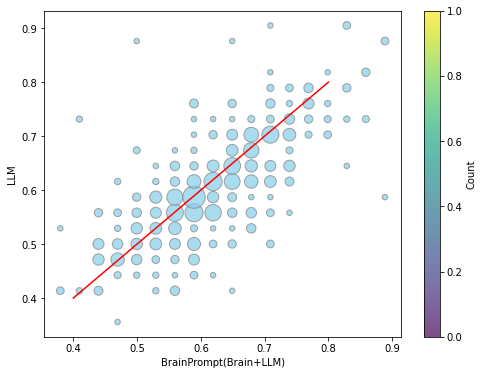

In [166]:
from matplotlib import pyplot as plt

def scatter_plot_comparation(result_1, result_2, metric='corpus_bleu_score_1'):
    if metric=='corpus_bleu_score_1':
        v_min, v_max = 0.3, 1.0
    elif metric=='bert_scores':
        v_min, v_max = 0.4, 0.8
    plt.figure(figsize=(8, 6)) 
    plt.xlim(v_min, v_max) 
    plt.ylim(v_min, v_max) 
    if metric == 'corpus_bleu_score_1':
        counts, xedges, yedges, _ = plt.hist2d(result_1["corpus_bleu_score"][1], result_2["corpus_bleu_score"][1], bins=20)
    elif metric == 'bert_scores':
        counts, xedges, yedges, _ = plt.hist2d(result_1["bert_scores"], result_2["bert_scores"], bins=20)
    # 将二维直方图的点数量作为散点的面积大小
    plt.cla()
    x = []
    y = []
    s = []
    for i in range(len(xedges[:-1])):
        for j in range(len(yedges[:-1])):
            if counts[i][j] >= 3:
                x.append(xedges[:-1][i])
                y.append(yedges[:-1][j])
                s.append(counts[i][j]*10)
    
    # 设置散点图的样式
    plt.scatter(x, y, s=s, c='skyblue', alpha=0.7, edgecolors='gray')  # 设置散点的大小、颜色、透明度和边界颜色

    plt.plot([v_min, v_max],[v_min, v_max], color='red')
    plt.xlabel('BrainPrompt(Brain+LLM)')
    plt.ylabel('LLM')
    plt.colorbar(label='Count')
    plt.show()
# result_1 = get_iterate_results(base_path = '../results/0827/', para_str = 'gpt2-xl_lr1e-5_tid1,2_0827', dataset_name='Pereira', print_log=True)
# result_2 = get_iterate_results(base_path = '../results/0827/', para_str = 'gpt2-xl_lr1e-5_tid1,2_0827_random', dataset_name='Pereira', print_log=True)
scatter_plot_comparation(result_1, result_2, metric = 'bert_scores')

